# Import Packages

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df_ = pd.read_csv("BBY.csv")
df = df_[['Date', 'Low', 'Adj Close']]

Our option starts from May 15th, 2019 and expires at May 14th, 2020

In [3]:
df.head(3)

,Date,Low,Adj Close
0,2019-05-15,67.019997,65.849869
1,2019-05-16,68.059998,66.703789
2,2019-05-17,68.000000,66.888161


# Determine some statistics  
Strike K = S0  ->  ATM Option  
Barrier L  ->  25  
Expiry T   ->  1 Year  
Sigma  ->  Annualized Vol of Return  
Interest r  ->  1 Year Libor at Beginning Day  
Rebate R  ->  0

In [4]:
K = df['Adj Close'].values[0]
T = 1

df['Return'] = df['Adj Close'].pct_change()
sigma = df['Return'].std() * np.sqrt(252)
df['Return'].iloc[0] = 0.0

L = 25
r = 0.026325 
R = 0 

df['Time'] = df.index / 252
df.tail(3)

df2 = df.copy()
df3 = df.copy()

In [5]:
print(sigma, K)

0.5071486821086896 65.849869


Generate a Signal  ->  To see whether already knocked-out or not yet  
if knocked out -> 1  
Otherwise -> 0

In [6]:
def Gen_Signal(Close, L):
    if Close <= L: 
        return 1
    else:
        return 0
    
def Knock_Out(Knock):
    if Knock > 0:
        return 1
    else:
        return 0

a = df['Adj Close'].apply(Gen_Signal, args=(L,))
df['Knock-Out'] = a.cumsum()
df['Knock-Out'] = df['Knock-Out'].apply(Knock_Out)
df

,Date,Low,Adj Close,Return,Time,Knock-Out
0,2019-05-15,67.019997,65.849869,0.000000,0.000000,0
1,2019-05-16,68.059998,66.703789,0.012968,0.003968,0
2,2019-05-17,68.000000,66.888161,0.002764,0.007937,0
3,2019-05-20,68.300003,66.800835,-0.001306,0.011905,0
4,2019-05-21,68.500000,67.877953,0.016124,0.015873,0
...,...,...,...,...,...,...
248,2020-05-08,76.730003,78.629997,0.031213,0.984127,0
249,2020-05-11,77.050003,78.019997,-0.007758,0.988095,0
250,2020-05-12,76.970001,77.050003,-0.012433,0.992063,0
251,2020-05-13,74.180000,75.029999,-0.026217,0.996032,0


# Define Class and Functions

In [7]:
class Down_Out_Rebate():
    def __init__(self, df, K, T, R, L, sigma, r):
        """
        Description: Price for Down Out Rebate Option and calculate its analytical Delta
        --------------------------------------------------------------------------------
        Param:
            df: pandas dataframe
                df of Stock Prices
            K: float
                Strike Price            
            T: float
                Expiry Time (year)
            R, L: float 
                Rebate & Barrier
            sigma: float
                Annualized Volatility of Return
            r: float
                1-Year Libor Rate
        --------------------------------------------------------------------------------
        """
        self.df = df
        self.K = K 
        self.T = T
        self.R = R 
        self.L = L 
        self.sigma = sigma
        self.r = r         
    
    def Black_Scholes(self, St, Knock_Out, t):
        """
        Description: Use Black-Scholes to Price Down Out Rebate Option and calculate its analytical Delta
            V = p(S,K,t) - p(S,L,t) + (R-K+L)Pd(S,L,t)
        -------------------------------------------------------------------------------------------------
        Param:
            St: float
                Stock Price at time t
            Knock_Out: int
                1: Already Knock out/ 0: Not yet
            t: float
                Current time (0-T year)
        -------------------------------------------------------------------------------------------------
        return:
            Option Price and Delta
        """
        if Knock_Out == 1: 
            price = np.exp(-self.r*(self.T-t)) * R 
            delta = 0  # No price change anymore
            return price, delta   
        
        if t == 1.0:  # Last Day and not knock out
            price = max(self.K - St, 0)
            delta = -1
            return price, delta
        
        denominator = self.sigma * np.sqrt(self.T-t)   # All "d have same denominator
        const = (self.r + 0.5 * (self.sigma**2) ) * (self.T-t) / denominator  # second term in d1

        d1 = np.log(St/self.K) / denominator + const
        d2 = d1 - denominator

        x1 = np.log(St/self.L) / denominator + const
        x2 = x1 - denominator
        
        y1 = np.log(self.L**2 / (St * self.K)) / denominator + const
        y2 = y1 - denominator
        
        y3 = np.log(self.L / St) / denominator + const
        y4 = y3 - denominator
        
        k = 2 * self.r / (self.sigma**2)
        discount = np.exp(-self.r*(self.T-t))
        
        if self.K < self.L:
            price1 = self.R * discount * ( norm.cdf(-x2) + LS_minus * norm.cdf(y4) )
            delta1 = - discount * self.R * (norm.pdf(x2) + np.power(self.L / St, k-1) * norm.pdf(y4) ) / (St * denominator) \
                     + discount * self.R * (1-k) * norm.cdf(y4) * np.power(self.L / St, k-1) / St 
            return price1, delta1
        
        LS_plus = np.power(self.L / St, k+1)
        LS_minus = np.power(self.L / St, k-1)
        price2 = -St * norm.cdf(-d1) + discount * self.K * norm.cdf(-d2) + St * norm.cdf(-x1) \
                 + (0 - self.K) * discount * norm.cdf(-x2) + St * norm.cdf(-y1) * LS_plus \
                 - discount * self.K * LS_minus * norm.cdf(-y2) - St * norm.cdf(-y3) * LS_plus \
                 - discount * (0 - self.K) * LS_minus * norm.cdf(-y4) + self.R * discount * ( norm.cdf(-x2) + LS_minus * norm.cdf(y4) )
        
        delta2 = -norm.cdf(-d1) - norm.cdf(-y1) * LS_plus - (1-k) * LS_minus / St \
                 * ( -(self.L*self.L)/St * norm.cdf(-y1) + discount * self.K * norm.cdf(-y2) ) \
                 + norm.cdf(-x1) + LS_plus * norm.cdf(-y3) + (1-k) * LS_minus / St \
                 * ( -(self.L*self.L)/St * norm.cdf(-y3) + discount * self.L * norm.cdf(-y4) ) \
                 - (0 - self.K + self.L) * discount / (denominator * St) * ( norm.pdf(-x2) + LS_minus * norm.pdf(-y4) ) \
                 - (0 - self.K + self.L) * discount / St * (1-k) * norm.cdf(-y4) * LS_minus - discount * self.R * (norm.pdf(x2) + np.power(self.L / St, k-1) * norm.pdf(y4) ) / (St * denominator) \
                 + discount * self.R * (1-k) * norm.cdf(y4) * np.power(self.L / St, k-1) / St 
        
        return price2, delta2
    
    
    def Monte_Carlo(self, St, Knock_Out, t, N):
        """
        Description: Use Monte Carlo Simulation to price Down Out Option with Rebate and calculate Delta
            S(t) follows Geometric Brownian Motion
            if Minimum of S(t) is less than Barrier -> Knock Out -> Get Rebate
            else -> Get Max(S(T)-K, 0)
        ------------------------------------------------------------------------------------------------
        Param:
            St: float
                Stock Price at time t   
            Knock_Out: int
                1: Already Knock out/ 0: Not yet
            t: float
                Current time (year)
            N: int
                Num of Loop
        ------------------------------------------------------------------------------------------------
        return:
            Option Price and Delta
        """
        if Knock_Out == 1: 
            price = np.exp(-self.r*(self.T-t)) * self.R 
            delta = 0  # No price change anymore
            return price, delta 
        
        if t == 1.0:  # Last Day
            price = max(self.K - St, 0)
            delta = -1
            return price, delta
        
        #np.random.seed(1)
        interval = 1/252
        days = int(252 * (1-t)) + 1
        Ratio = np.random.normal(0, 1, [N, days])  # Generate a matrix, with N rows and days' columns
        Ratio = (self.r - 0.5*self.sigma*self.sigma) * interval + self.sigma * np.sqrt(interval) * Ratio  # Log GBM ratio -> log(S(t) / S(t-1))
        Ratio = np.exp(Ratio)  # GBM ratio -> S(t) / S(t-1)
        Ratio = Ratio.cumprod(axis = 1)  # GBM ratio -> S(t+i) / S(t)
        
        S_mat = St * Ratio  # N * days Matrix -> Every Column is the time series for stock price
        S_plus_mat = (St + 0.01) * Ratio  # Used to Calculate Delta
        S_minus_mat = (St - 0.01) * Ratio
        
        Options = np.array([self.R] * N)  # Initialize Option Payoff with R
        Options_plus = np.array([self.R] * N)  
        Options_minus = np.array([self.R] * N)
        for i in range(N):
            S = S_mat[i]  # ith Series of Stock Prices from t to T
            S_plus = S_plus_mat[i]  # Used for Calculating Delta
            S_minus = S_minus_mat[i]

            if min(S) > self.L:  # If S not Knocked-Out
                Options[i] = max(self.K - S[-1], 0)
                Options_plus[i] = max(self.K - S_plus[-1], 0)  # S_plus will not knock out if S not
                if min(S_minus) > self.L:  # S_minus not knock-out, in the prerequisite S not knock out
                    Options_minus[i] = max(self.K - S_minus[-1], 0)

        price = np.exp(-self.r*(self.T - t)) * np.mean(Options)
        delta = np.exp(-self.r*(self.T - t)) * ( np.mean(Options_plus) - np.mean(Options_minus) ) / 0.02
        return price, delta
    
    def Price_Delta(self, N):
        """
        Description: Use BS formula and Monte Carlo Simulation to price Down Out Option with Rebate and calculate Delta
        ----------------------------------------------------------------------
        """
        self.df['BS Price'] = self.df.apply(lambda row: self.Black_Scholes(row['Adj Close'], row['Knock-Out'], row['Time'])[0], axis=1)
        self.df['BS Delta'] = self.df.apply(lambda row: self.Black_Scholes(row['Adj Close'], row['Knock-Out'], row['Time'])[1], axis=1)
        # Last Day's Delta = -1 if not Knock out(0-1); Delta = 0 if Knock Out (1-1)
        self.df['BS Delta'].iloc[-1] = self.df['Knock-Out'].iloc[-1] - 1
        
        np.random.seed(1)
        MC_res = self.df.apply(lambda row: self.Monte_Carlo(row['Adj Close'], row['Knock-Out'], row['Time'], N), axis=1)
        price = []; delta = []
        for i in range(len(MC_res)):
            price.append(MC_res[i][0])
            delta.append(MC_res[i][1])
        self.df['MC Price'], self.df['MC Delta'] = price, delta
        self.df['MC Delta'].iloc[-1] = self.df['Knock-Out'].iloc[-1] - 1
        
    def Cal_PnL(self):
        """
        Description: Calculate Daily PnL
        --------------------------------
        """
        self.df['BS PnL'] = self.df['BS Price'].diff() - self.df['BS Delta'].shift(1) * self.df['Adj Close'].diff()
        self.df['BS PnL'].iloc[0] = 0.0;  # No PnL at first day
        self.df['BS Cumu PnL'] = self.df['BS PnL'].cumsum()
        
        self.df['MC PnL'] = self.df['MC Price'].diff() - self.df['MC Delta'].shift(1) * self.df['Adj Close'].diff()
        self.df['MC PnL'].iloc[0] = 0.0 
        self.df['MC Cumu PnL'] = self.df['MC PnL'].cumsum()
        
    def Plot_PnL(self):
        """
        Description: Plot Daily PnL and Cumulative PnL
        ----------------------------------------------
        """
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        plt.figure(figsize=(20, 16), dpi = 120)

        ax1 = plt.subplot(211)
        plt.plot(self.df['Date'], self.df['BS PnL'], color = "g", label = 'Black-Scholes')
        plt.plot(self.df['Date'], self.df['MC PnL'], color = "orange", label = 'Monte-Carlo')
        plt.ylabel('Dollar')
        plt.xlabel('Date')
        plt.title('Daily PnL (L=' + str(self.L) + ')')
        plt.legend()
        
        ax2 = plt.subplot(212)
        plt.plot(self.df['Date'], self.df['BS Cumu PnL'], color = "g", label = 'Black-Scholes')
        plt.plot(self.df['Date'], self.df['MC Cumu PnL'], color = "orange", label = 'Monte-Carlo')
        plt.ylabel('Dollar')
        plt.xlabel('Date')
        plt.title('Cumulative PnL (L=' + str(self.L) + ')')
        plt.legend()
        plt.show()

In [8]:
def Plot_Converge(price_list, price1, delta_list, delta1):
    plt.figure(figsize=(12, 12), dpi = 80)
    ax1 = plt.subplot(211)
    plt.plot(np.linspace(0, 30, 31), price_list, label = 'Down Out Put with Rebate')
    plt.plot(np.linspace(0, 30, 31), [price1] * 31, label = 'Vanilla Put')
    plt.title("Option Price")
    plt.xlabel("Barrier L")
    plt.ylabel("Option Price")
    plt.legend()

    ax2 = plt.subplot(212)
    plt.plot(np.linspace(0, 30, 31), delta_list, label = 'Down Out Put with Rebate')
    plt.plot(np.linspace(0, 30, 31), [delta1] * 31, label = 'Vanilla Put')
    plt.title("Delta")
    plt.xlabel("Barrier L")
    plt.ylabel("Delta")
    plt.legend()
    plt.show()
    
def Plot_Delta(obj):
    plt.figure(figsize=(12,6))
    plt.plot(obj.df['Date'], obj.df['BS Delta'], color = "g", label = 'Black-Scholes')
    plt.plot(obj.df['Date'], obj.df['MC Delta'], color = "orange", label = 'Monte-Carlo')
    plt.ylabel('Delta')
    plt.xlabel('Date')
    plt.title('Delta (L=' + str(obj.L) + ')')
    plt.legend()
    plt.show()
    
def Plot_Option_Price(obj):
    plt.figure(figsize=(12,6))
    plt.plot(obj.df['Date'], obj.df['BS Price'], color = "g", label = 'Black-Scholes')
    plt.plot(obj.df['Date'], obj.df['MC Price'], color = "orange", label = 'Monte-Carlo')
    plt.ylabel('Option Price')
    plt.xlabel('Date')
    plt.title('Option Price (L=' + str(obj.L) + ')')
    plt.legend()
    plt.show()

# Test ->  L = 25
Strike K = 65.85   
Expiry T = 1  
Barrier L = 25   
Rebate R = 0  
Vol of Return Sigma = 50.71%   
1-Year Libor r = 2.6325%   

In [9]:
obj = Down_Out_Rebate(df, K, T, R, L, sigma, r)
obj.Price_Delta(N = 10000)
obj.Cal_PnL()

## Show Price, Delta, PnL Table

In [10]:
obj.df

,Date,Low,Adj Close,Return,Time,Knock-Out,BS Price,BS Delta,MC Price,MC Delta,BS PnL,BS Cumu PnL,MC PnL,MC Cumu PnL
0,2019-05-15,67.019997,65.849869,0.000000,0.000000,0,8.949113,-0.178036,8.941879,-0.258115,0.000000,0.000000,0.000000,0.000000
1,2019-05-16,68.059998,66.703789,0.012968,0.003968,0,8.801552,-0.180503,8.864592,-0.316589,0.004468,0.004468,0.143122,0.143122
2,2019-05-17,68.000000,66.888161,0.002764,0.007937,0,8.773007,-0.181879,8.796640,-0.336107,0.004734,0.009201,-0.009581,0.133541
3,2019-05-20,68.300003,66.800835,-0.001306,0.011905,0,8.793651,-0.182945,8.835558,-0.180250,0.004762,0.013963,0.009567,0.143107
4,2019-05-21,68.500000,67.877953,0.016124,0.015873,0,8.599506,-0.184953,8.349268,-0.165652,0.002909,0.016872,-0.292139,-0.149032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2020-05-08,76.730003,78.629997,0.031213,0.984127,0,0.003707,-0.002442,0.008297,0.000000,0.010159,4.262482,0.011495,4.988532
249,2020-05-11,77.050003,78.019997,-0.007758,0.988095,0,0.001179,-0.000974,0.000500,0.000000,-0.004018,4.258464,-0.007797,4.980735
250,2020-05-12,76.970001,77.050003,-0.012433,0.992063,0,0.000203,-0.000229,0.000200,0.000000,-0.001921,4.256544,-0.000300,4.980435
251,2020-05-13,74.180000,75.029999,-0.026217,0.996032,0,0.000011,-0.000020,0.000000,0.000000,-0.000655,4.255889,-0.000200,4.980235


## Plot PnL Time Series by BS and MC

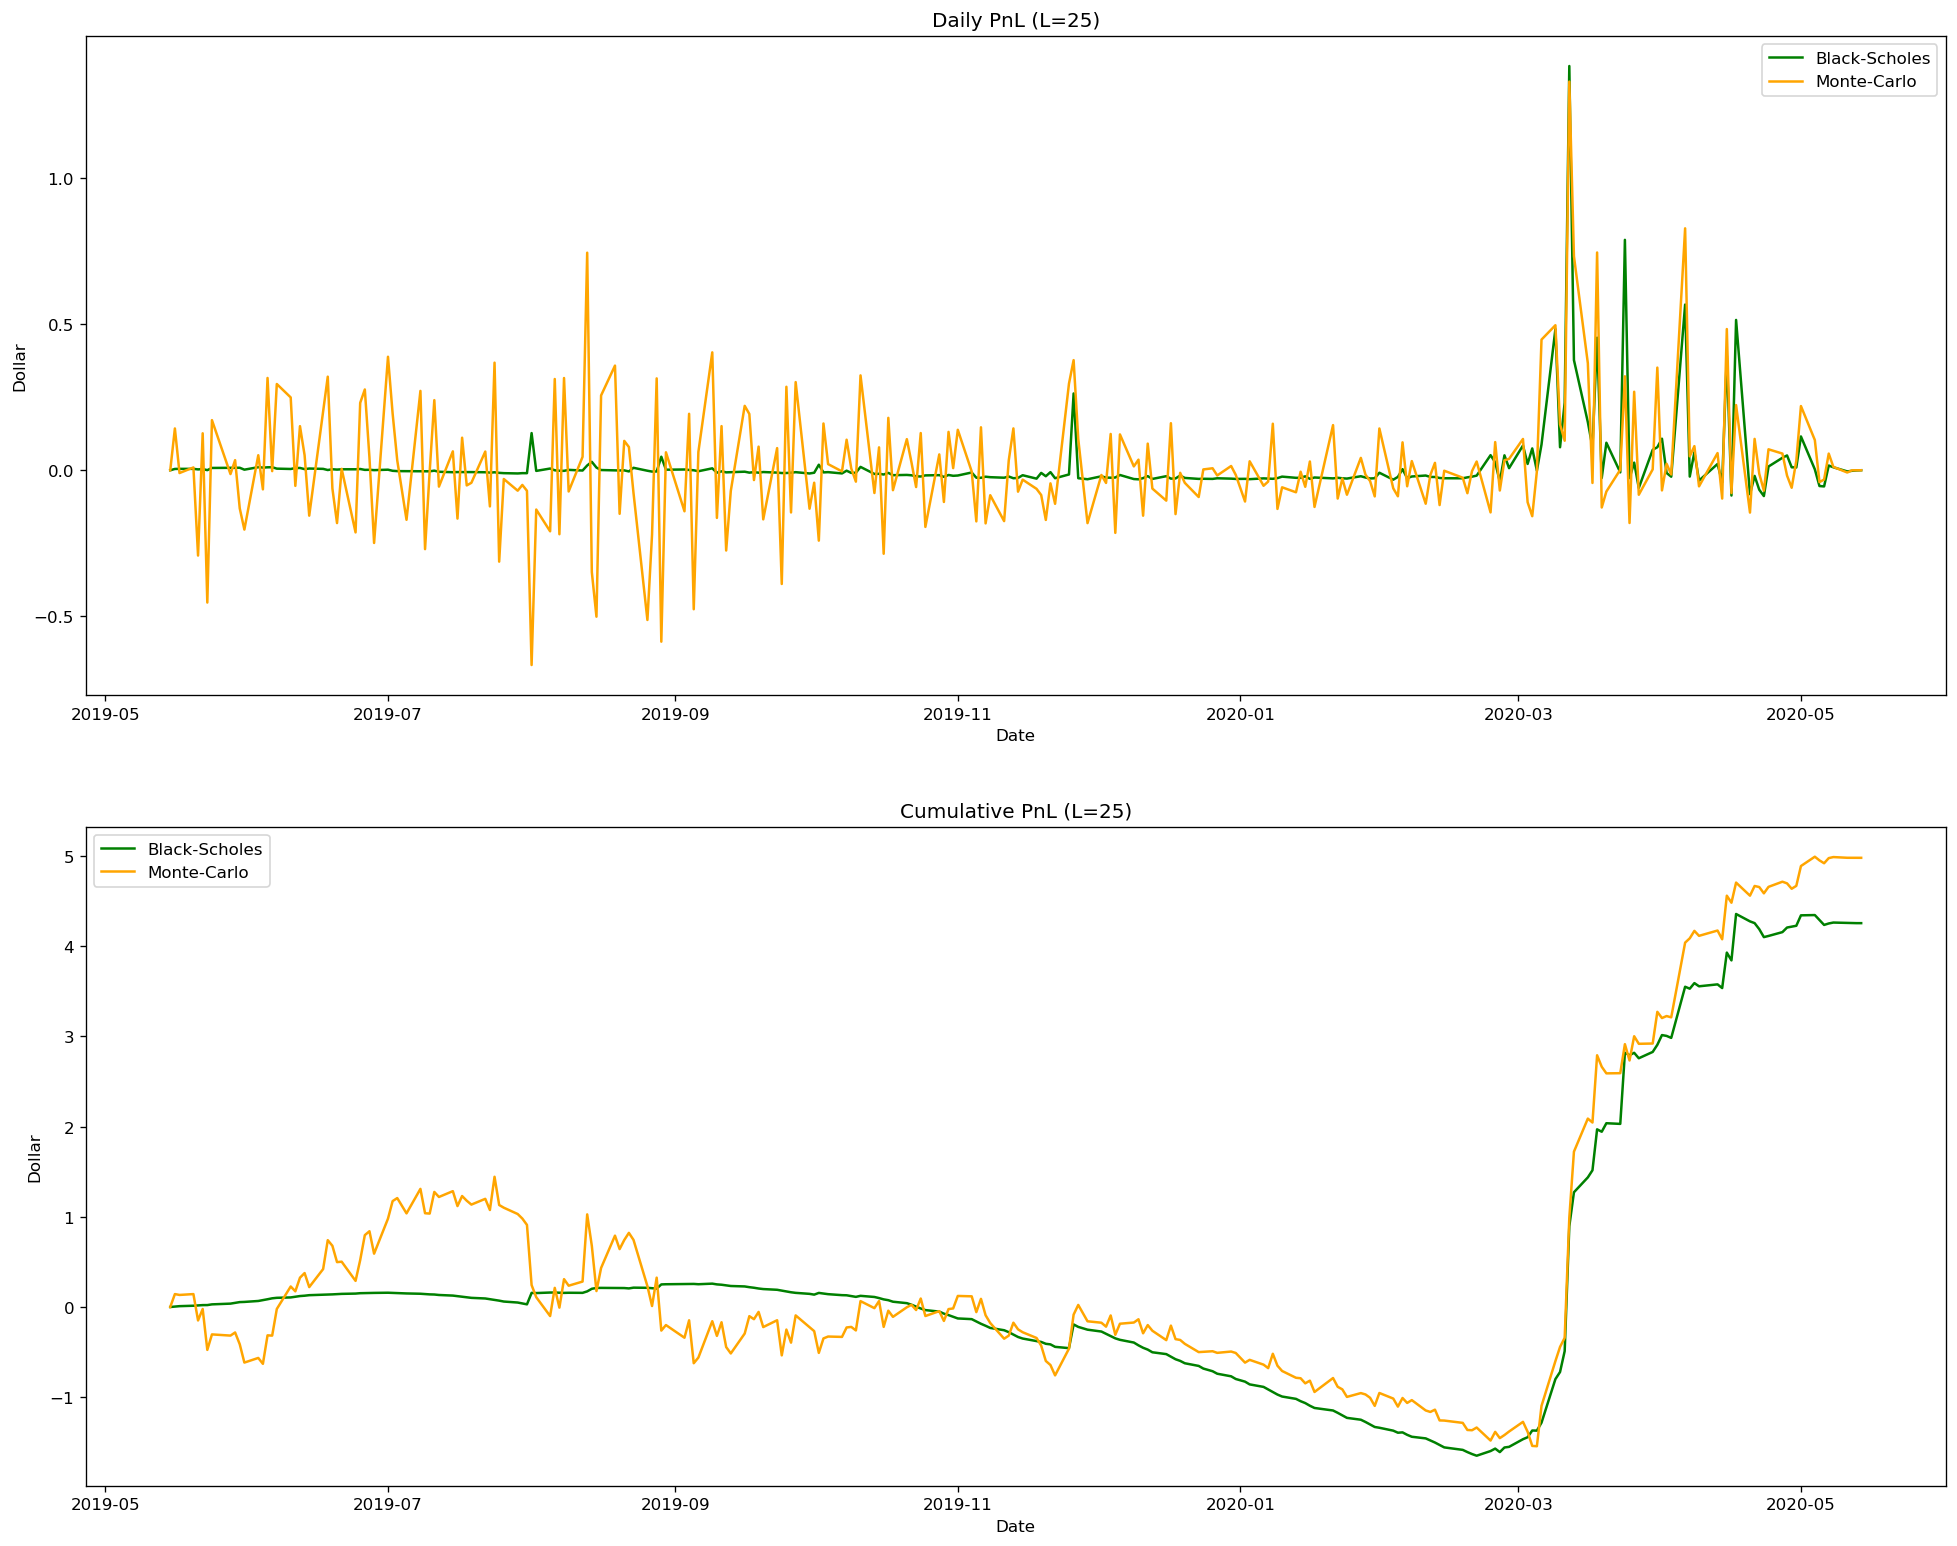

In [11]:
obj.Plot_PnL()

Fuse Happened during these few days

In [12]:
obj.df[obj.df['Date'] >= "2020-03-10"]

,Date,Low,Adj Close,Return,Time,Knock-Out,BS Price,BS Delta,MC Price,MC Delta,BS PnL,BS Cumu PnL,MC PnL,MC Cumu PnL
206,2020-03-10,66.419998,69.480644,0.048602,0.817460,0,4.060618,-0.352589,3.942907,-0.353298,0.078744,-0.720716,0.157087,-0.442640
207,2020-03-11,63.840000,64.773956,-0.067741,0.821429,0,5.951506,-0.479003,5.706909,-0.482725,0.231363,-0.489353,0.101138,-0.341502
208,2020-03-12,55.200001,54.894863,-0.152516,0.825397,0,12.067856,-0.763814,11.806607,-0.846102,1.384230,0.894877,1.330808,0.989306
209,2020-03-13,54.389999,60.503254,0.102166,0.829365,0,8.161311,-0.609019,7.794110,-0.547535,0.377221,1.272098,0.732774,1.722080
210,2020-03-16,49.009998,56.777538,-0.061579,0.833333,0,10.595240,-0.721367,10.200746,-0.706892,0.164899,1.436997,0.366676,2.088756
211,2020-03-17,55.320000,59.770000,0.052705,0.837302,0,8.515489,-0.636541,8.041882,-0.602414,0.078912,1.515909,-0.043517,2.045239
212,2020-03-18,49.900002,54.000000,-0.096537,0.841270,0,12.642197,-0.802389,12.263449,-0.811602,0.453868,1.969778,0.745636,2.790875
213,2020-03-19,48.110001,54.750000,0.013889,0.845238,0,12.013828,-0.787851,11.527241,-0.831605,-0.026577,1.943201,-0.127507,2.663368
214,2020-03-20,51.590000,51.650002,-0.056621,0.849206,0,14.550426,-0.862818,14.032286,-0.871533,0.094261,2.037462,-0.072929,2.590440
215,2020-03-23,49.009998,50.689999,-0.018587,0.853175,0,15.371511,-0.884819,14.870810,-0.801895,-0.007223,2.030238,0.001850,2.592289


## Compare Deltas between BS & MC

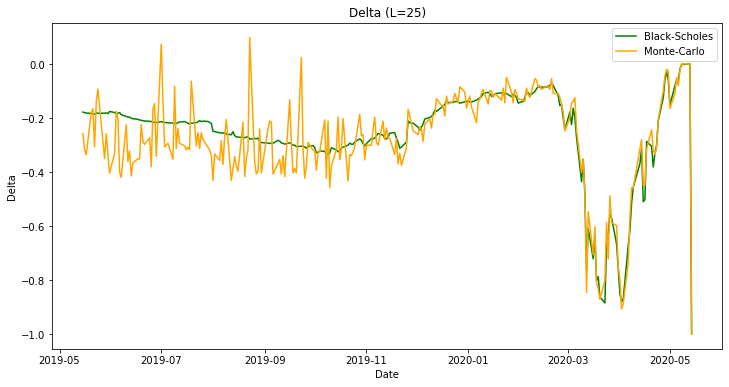

In [13]:
Plot_Delta(obj)

plt.figure(figsize=(12,6))
plt.plot(obj.df['Date'], obj.df['BS Delta'], color = "g", label = 'Black-Scholes')
plt.plot(obj.df['Date'], obj.df['MC Delta'], color = "orange", label = 'Monte-Carlo')
plt.ylabel('Delta')
plt.xlabel('Date')
plt.title('Delta')
plt.legend()
plt.show()

## Compare Option Prices between BS & MC

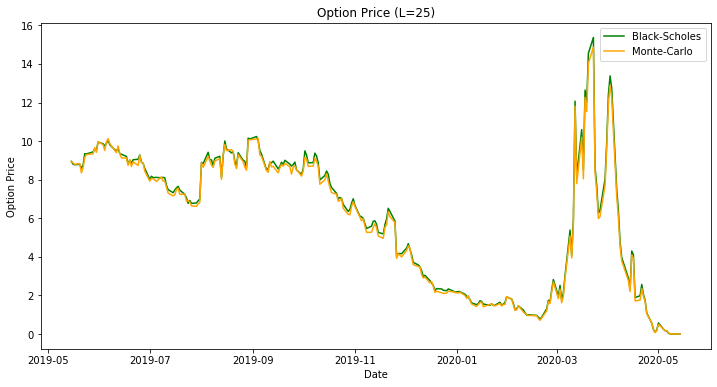

In [14]:
Plot_Option_Price(obj)

plt.figure(figsize=(12,6))
plt.plot(obj.df['Date'], obj.df['BS Price'], color = "g", label = 'Black-Scholes')
plt.plot(obj.df['Date'], obj.df['MC Price'], color = "orange", label = 'Monte-Carlo')
plt.ylabel('Option Price')
plt.xlabel('Date')
plt.title('Option Price')
plt.legend()
plt.show()

## VaR & ES Analysis - Based on PnL

### 95% VaR  
VaR = avg + z_score * std  

In [15]:
dfx = obj.df.copy()
VaR = -dfx['MC PnL'].mean() + norm.ppf(0.95) * dfx['MC PnL'].std()
print("95% VaR on PnL is {:.2f}".format(VaR))

95% VaR on PnL is 0.34


### Expected Shortfall (ES) on 95%  
ES = Mean( Biggest 5% Loss )

In [16]:
dfxx = dfx.copy()[['MC PnL']].iloc[1:]  # Delete the first day  ->  No PnL this day
dfxx = dfxx.sort_values('MC PnL', ascending = True)
N = int( 252 * 0.05 )
ES = -dfxx['MC PnL'].iloc[:N].mean()
print("95% ES on PnL is {:.2f}".format(ES))

95% ES on PnL is 0.43


## Extreme Test (L gradually decreasing to 0)
We want to explore whether price of Down-Out Put approaches price of Vanilla Put when L gets close to 0  
We just use the first day's stock price and set L = 0.01

In [17]:
def Vanilla_Put(St, K, T, t, sigma, r):
    d1 = (np.log(St / K) + (r + sigma*sigma / 2) * (T-t)) / (sigma * np.sqrt(T-t))
    N_d1 = norm.cdf(-d1, 0, 1)
    d2 = d1 - sigma * np.sqrt(T-t)
    N_d2 = norm.cdf(-d2, 0, 1)
    price = -St * N_d1 + K * np.exp(-r*(T-t)) * N_d2
    delta = -N_d1
    
    return price, delta

St_ = 65.85
K_ = 65.85
T_ = 1
t_ = 0
#L_ = 0.01
R_ = 0
sigma_ = 50.71/100
r_ = 2.6325/100

### Price & Delta of Vanilla Put

In [18]:
price1, delta1 = Vanilla_Put(St_, K_, T_, t_, sigma_, r_)
print("Price of Vanilla Put is {:.2f}".format(price1))
print("Delta of Vanilla Put is {:.2f}".format(delta1))

Price of Vanilla Put is 12.17
Delta of Vanilla Put is -0.38


### Price & Delta of Down-Out Put with Rebate (L gradually decreasing to 0)

Price of Down-Out Put with Rebate is 12.17
Delta of Down-Out Put with Rebate is -0.38


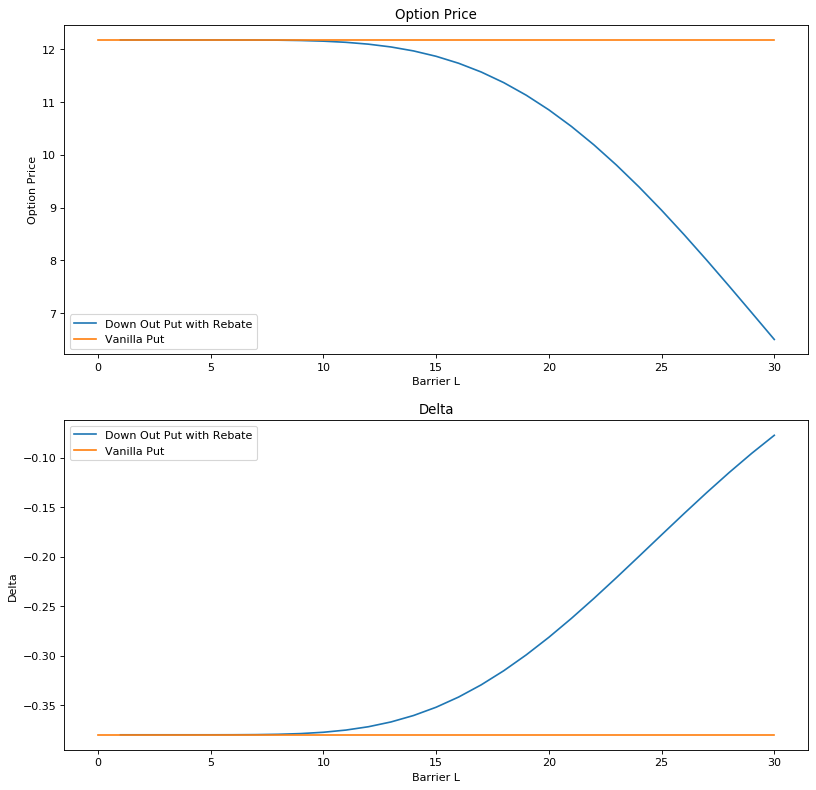

In [19]:
price_list = []
delta_list = []

obj_ = Down_Out_Rebate(df, K_, T_, R_, 0.01, sigma_, r_)
price2, delta2 = obj_.Black_Scholes(St_, 0, t_)
print("Price of Down-Out Put with Rebate is {:.2f}".format(price2))
print("Delta of Down-Out Put with Rebate is {:.2f}".format(delta2))

for L_ in np.linspace(0, 30, 31):
    obj_ = Down_Out_Rebate(df, K_, T_, R_, L_, sigma_, r_)
    price2, delta2 = obj_.Black_Scholes(St_, 0, t_)
    price_list.append(price2)
    delta_list.append(delta2)

Plot_Converge(price_list, price1, delta_list, delta1)

Price of Down-Out Put with Rebate is 12.17
Delta of Down-Out Put with Rebate is -0.38


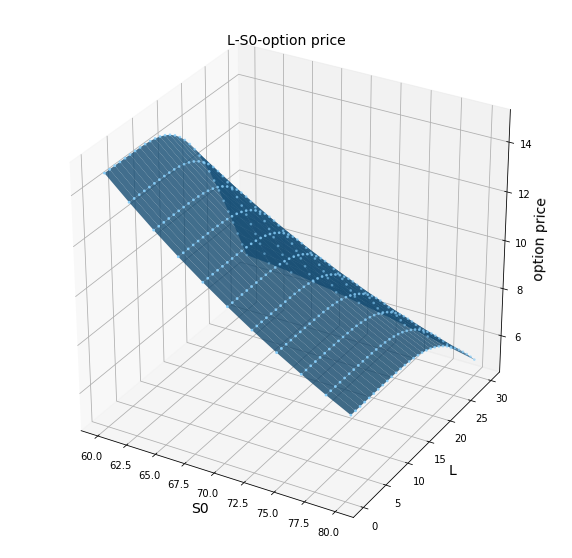

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

#module1,ax = plt.subplots(figsize=(8, 8))
module = plt.figure(figsize=(10, 10)).gca(projection='3d')
plt.title('L-S0-option price',fontsize=14)
#plt.xlabel('S0',fontsize=14)
#plt.ylabel('L',fontsize=14)
module.set_zlabel('option price',fontsize=14)

price_list = []
delta_list = []

obj_ = Down_Out_Rebate(df, K_, T_, R_, 0.01, sigma_, r_)
price2, delta2 = obj_.Black_Scholes(St_, 0, t_)
print("Price of Down-Out Put with Rebate is {:.2f}".format(price2))
print("Delta of Down-Out Put with Rebate is {:.2f}".format(delta2))

D3X = []
D3Y = []
D3Z = []
for S0 in np.linspace(60, 80, 11):
    price_list = []
    delta_list = []
    for L_ in np.linspace(0, 30, 31):
        obj_ = obj = Down_Out_Rebate(df, K_, T_, R_, L_, sigma_, r_)
        price2, delta2 = obj_.Black_Scholes(S0, 0, t_)
        price_list.append(price2)
        delta_list.append(delta2)
    #ax.plot(np.linspace(0, 30, 31),price_list)
    #ax.legend(labels=list(df['Tenor']))
    D3X = D3X+[[S0]*len(np.linspace(0, 30, 31))]           #S0_list.append(S0)
    D3Y = D3Y + [np.linspace(0, 30, 31)]
    D3Z = D3Z + [price_list]
D3Z = np.array(D3Z)

#module.plot_surface(D3Y,D3X,D3Z,alpha=0.8)
#module.scatter(D3Y,D3X,D3Z,c='lightskyblue',s=3)
plt.xlabel('S0',fontsize=14)
plt.ylabel('L',fontsize=14)
module.plot_surface(D3X,D3Y,D3Z,alpha=0.8)
module.scatter(D3X,D3Y,D3Z,c='lightskyblue',s=3)

# Test ->  L = 35

In [21]:
L2 = 35
a = df2['Adj Close'].apply(Gen_Signal, args=(L2,))
df2['Knock-Out'] = a.cumsum()
df2['Knock-Out'] = df2['Knock-Out'].apply(Knock_Out)

obj2 = Down_Out_Rebate(df2, K, T, R, L2, sigma, r)
obj2.Price_Delta(N = 10000)
obj2.Cal_PnL()

## Show Price, Delta, PnL Table

In [22]:
obj2.df

,Date,Low,Adj Close,Return,Time,Knock-Out,BS Price,BS Delta,MC Price,MC Delta,BS PnL,BS Cumu PnL,MC PnL,MC Cumu PnL
0,2019-05-15,67.019997,65.849869,0.000000,0.000000,0,4.085300,-0.008814,4.374804,-0.209414,0.000000,0.000000,0.000000,0.000000
1,2019-05-16,68.059998,66.703789,0.012968,0.003968,0,4.087832,-0.013752,4.238495,-0.053577,0.010059,0.010059,0.042513,0.042513
2,2019-05-17,68.000000,66.888161,0.002764,0.007937,0,4.097134,-0.015181,4.159831,-0.024356,0.011838,0.021897,-0.068786,-0.026273
3,2019-05-20,68.300003,66.800835,-0.001306,0.011905,0,4.110448,-0.015251,4.227396,0.029230,0.011988,0.033885,0.065439,0.039166
4,2019-05-21,68.500000,67.877953,0.016124,0.015873,0,4.102657,-0.020992,4.059262,-0.165652,0.008637,0.042522,-0.199618,-0.160452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2020-05-08,76.730003,78.629997,0.031213,0.984127,0,0.003707,-0.002442,0.008297,0.000000,0.010159,1.111450,0.011495,6.990817
249,2020-05-11,77.050003,78.019997,-0.007758,0.988095,0,0.001179,-0.000974,0.000500,0.000000,-0.004018,1.107432,-0.007797,6.983020
250,2020-05-12,76.970001,77.050003,-0.012433,0.992063,0,0.000203,-0.000229,0.000200,0.000000,-0.001921,1.105512,-0.000300,6.982720
251,2020-05-13,74.180000,75.029999,-0.026217,0.996032,0,0.000011,-0.000020,0.000000,0.000000,-0.000655,1.104857,-0.000200,6.982521


## Plot PnL Time Series by BS and MC

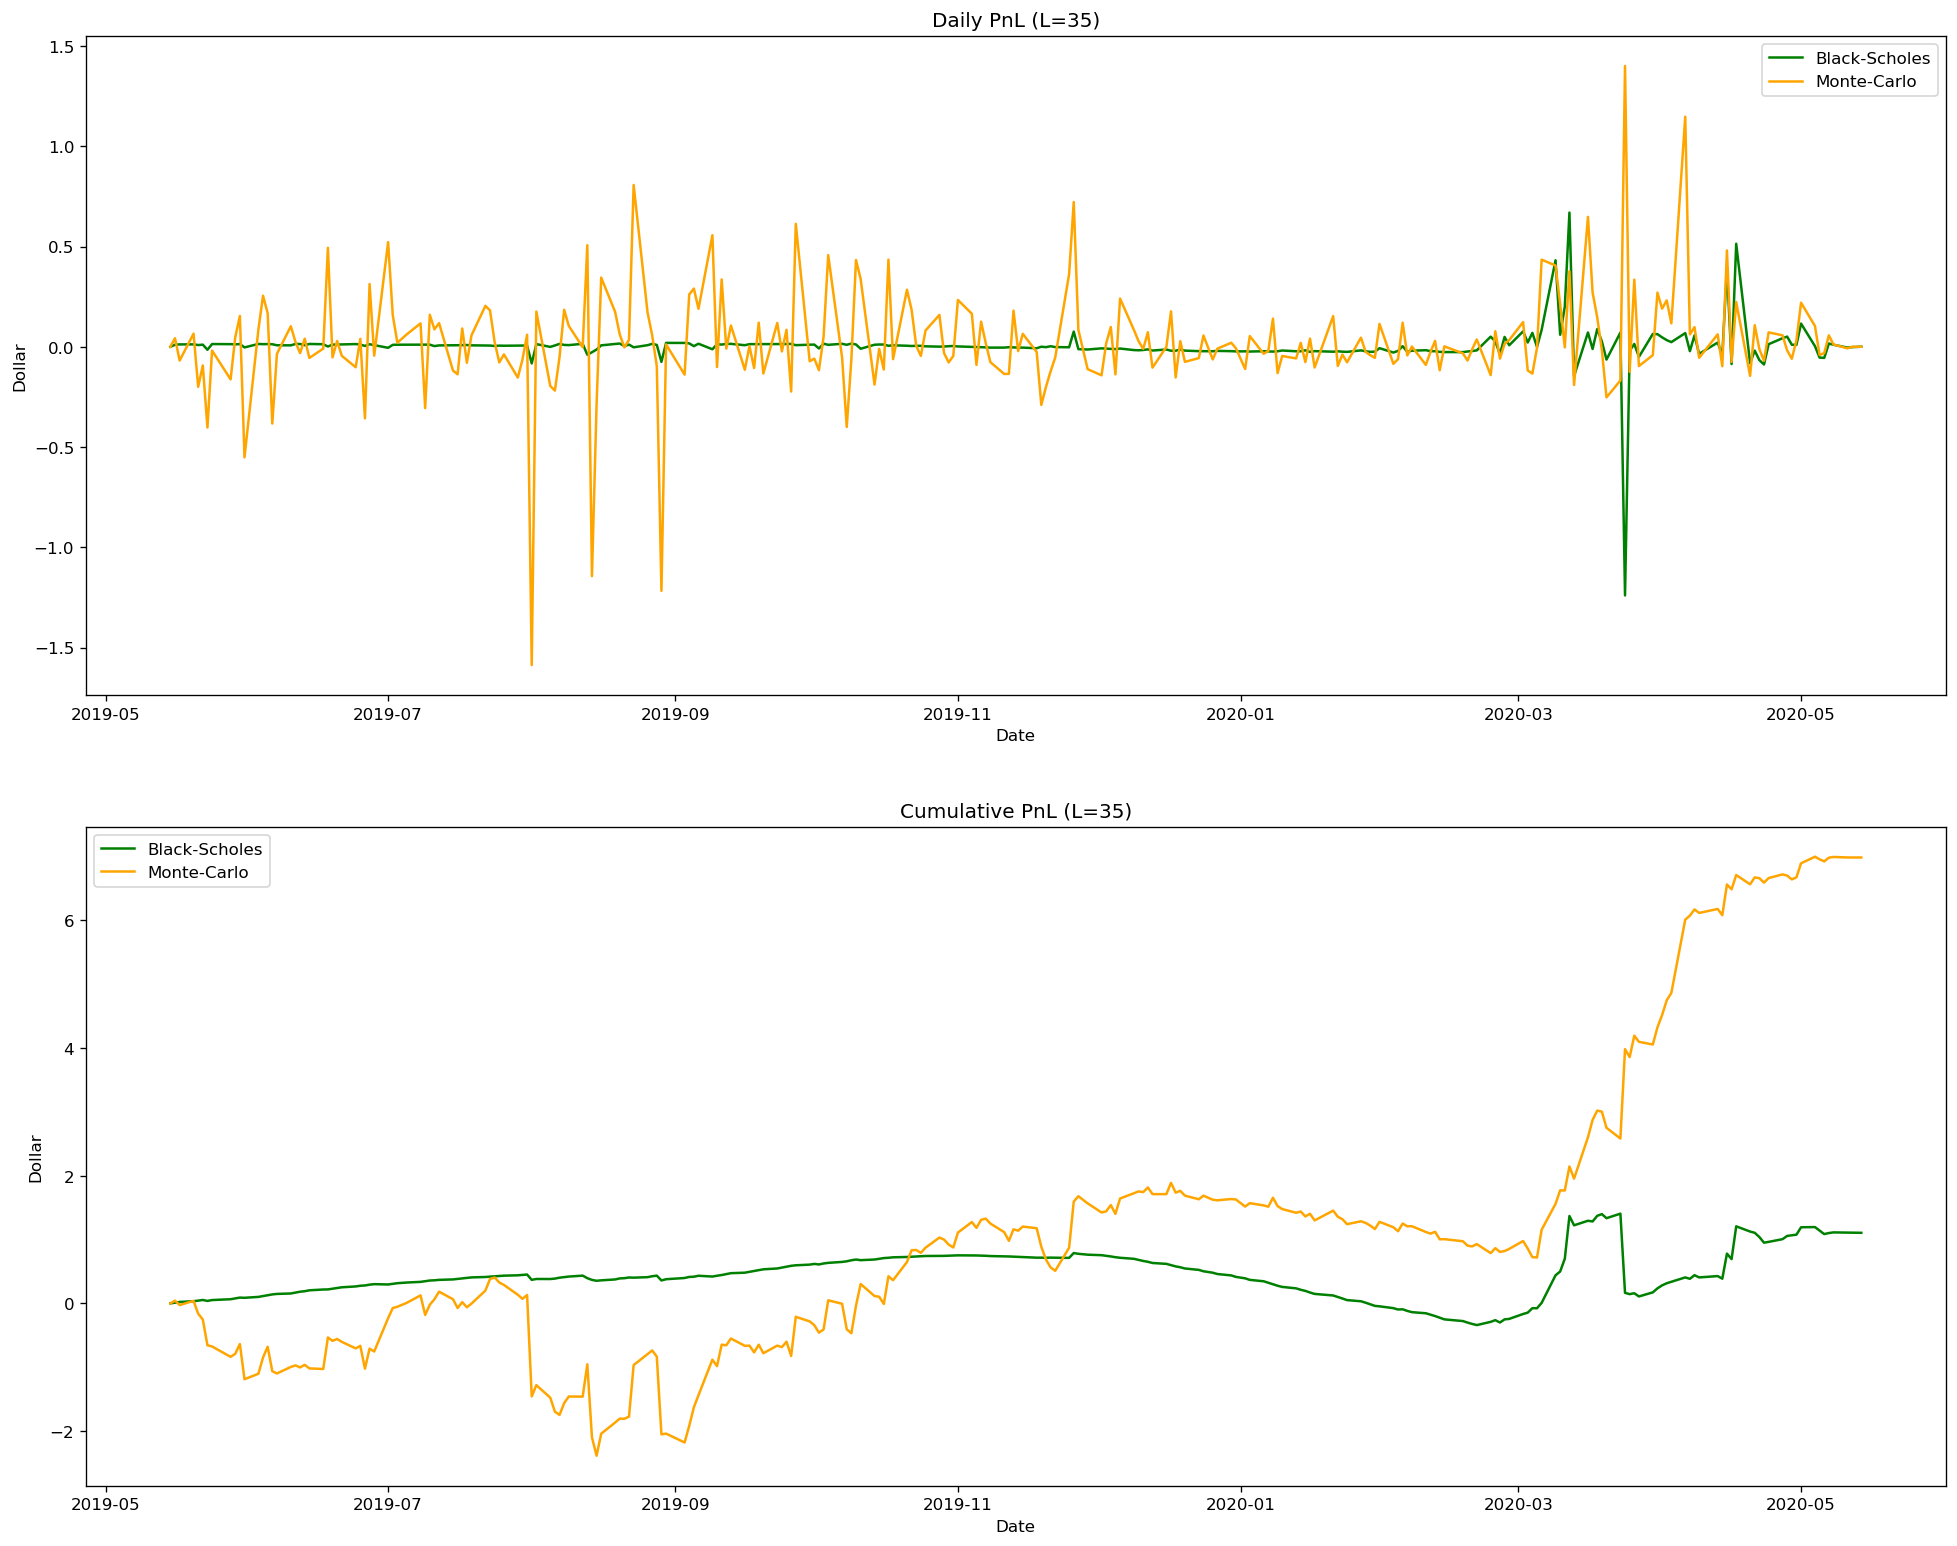

In [23]:
obj2.Plot_PnL()

In [24]:
obj2.df[obj2.df['Date'] >= "2020-03-10"]

,Date,Low,Adj Close,Return,Time,Knock-Out,BS Price,BS Delta,MC Price,MC Delta,BS PnL,BS Cumu PnL,MC PnL,MC Cumu PnL
206,2020-03-10,66.419998,69.480644,0.048602,0.817460,0,3.998388,-0.338755,3.903995,-0.353298,0.059891,0.499092,0.212309,1.770183
207,2020-03-11,63.840000,64.773956,-0.067741,0.821429,0,5.792820,-0.443859,5.563784,-0.482725,0.200019,0.699111,-0.003075,1.767107
208,2020-03-12,55.200001,54.894863,-0.152516,0.825397,0,10.847029,-0.513507,10.709362,-0.542501,0.669282,1.368394,0.376689,2.143796
209,2020-03-13,54.389999,60.503254,0.102166,0.829365,0,7.821083,-0.532894,7.476241,-0.398207,-0.145998,1.222396,-0.190564,1.953232
210,2020-03-16,49.009998,56.777538,-0.061579,0.833333,0,9.877769,-0.563704,9.607853,-0.701914,0.071273,1.293669,0.648004,2.601236
211,2020-03-17,55.320000,59.770000,0.052705,0.837302,0,8.179866,-0.558530,7.778214,-0.592457,-0.011040,1.282629,0.270811,2.872047
212,2020-03-18,49.900002,54.000000,-0.096537,0.841270,0,11.490954,-0.547834,11.343302,-0.781727,0.088372,1.371001,0.146611,3.018658
213,2020-03-19,48.110001,54.750000,0.013889,0.845238,0,11.106945,-0.580120,10.740154,-0.677235,0.026866,1.397867,-0.016853,3.001805
214,2020-03-20,51.590000,51.650002,-0.056621,0.849206,0,12.841340,-0.482752,12.587333,-0.841652,-0.063974,1.333893,-0.252249,2.749556
215,2020-03-23,49.009998,50.689999,-0.018587,0.853175,0,13.375711,-0.438898,13.227076,-0.757068,0.070927,1.404821,-0.168246,2.581310


## Compare Deltas between BS & MC

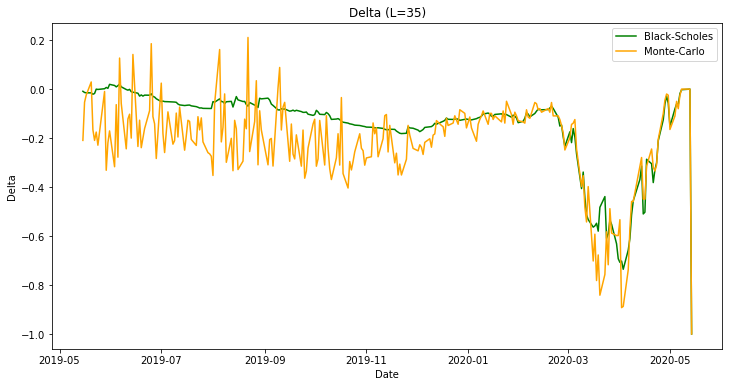

In [25]:
Plot_Delta(obj2)

## Compare Option Prices between BS & MC

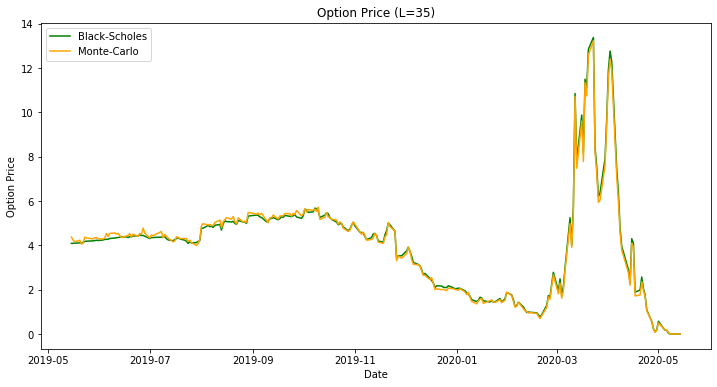

In [26]:
Plot_Option_Price(obj2)

## VaR & ES Analysis - Based on PnL

In [27]:
dfx = obj2.df.copy()
VaR = -dfx['MC PnL'].mean() + norm.ppf(0.95) * dfx['MC PnL'].std()
print("95% VaR on PnL is {:.2f}".format(VaR))

95% VaR on PnL is 0.40


In [28]:
dfxx = dfx.copy()[['MC PnL']].iloc[1:]  # Delete the first day  ->  No PnL this day
dfxx = dfxx.sort_values('MC PnL', ascending = True)
N = int( 252 * 0.05 )
ES = -dfxx['MC PnL'].iloc[:N].mean()
print("95% ES on PnL is {:.2f}".format(ES))

95% ES on PnL is 0.60


# Test ->  L = 45

In [29]:
L3 = 45
a = df3['Adj Close'].apply(Gen_Signal, args=(L3,))
df3['Knock-Out'] = a.cumsum()
df3['Knock-Out'] = df3['Knock-Out'].apply(Knock_Out)

obj3 = Down_Out_Rebate(df3, K, T, R, L3, sigma, r)
obj3.Price_Delta(N = 10000)
obj3.Cal_PnL()

## Show Price, Delta, PnL Table

In [30]:
obj3.df

,Date,Low,Adj Close,Return,Time,Knock-Out,BS Price,BS Delta,MC Price,MC Delta,BS PnL,BS Cumu PnL,MC PnL,MC Cumu PnL
0,2019-05-15,67.019997,65.849869,0.000000,0.000000,0,0.932438,0.022994,1.026128,0.029221,0.000000,0.000000,0.000000,0.000000
1,2019-05-16,68.059998,66.703789,0.012968,0.003968,0,0.955861,0.021280,1.067928,-0.097412,0.003789,0.003789,0.016848,0.016848
2,2019-05-17,68.000000,66.888161,0.002764,0.007937,0,0.964322,0.020927,1.003351,-0.102293,0.004537,0.008326,-0.046617,-0.029769
3,2019-05-20,68.300003,66.800835,-0.001306,0.011905,0,0.967090,0.021125,1.081110,0.160763,0.004596,0.012922,0.068826,0.039056
4,2019-05-21,68.500000,67.877953,0.016124,0.015873,0,0.993320,0.018956,1.057349,-0.112059,0.003475,0.016397,-0.196922,-0.157865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,2020-05-08,76.730003,78.629997,0.031213,0.984127,0,0.003707,-0.002442,0.008297,0.000000,0.010159,-6.825551,0.011495,-4.370583
249,2020-05-11,77.050003,78.019997,-0.007758,0.988095,0,0.001179,-0.000974,0.000500,0.000000,-0.004018,-6.829568,-0.007797,-4.378379
250,2020-05-12,76.970001,77.050003,-0.012433,0.992063,0,0.000203,-0.000229,0.000200,0.000000,-0.001921,-6.831489,-0.000300,-4.378679
251,2020-05-13,74.180000,75.029999,-0.026217,0.996032,0,0.000011,-0.000020,0.000000,0.000000,-0.000655,-6.832144,-0.000200,-4.378879


## Plot PnL Time Series by BS and MC

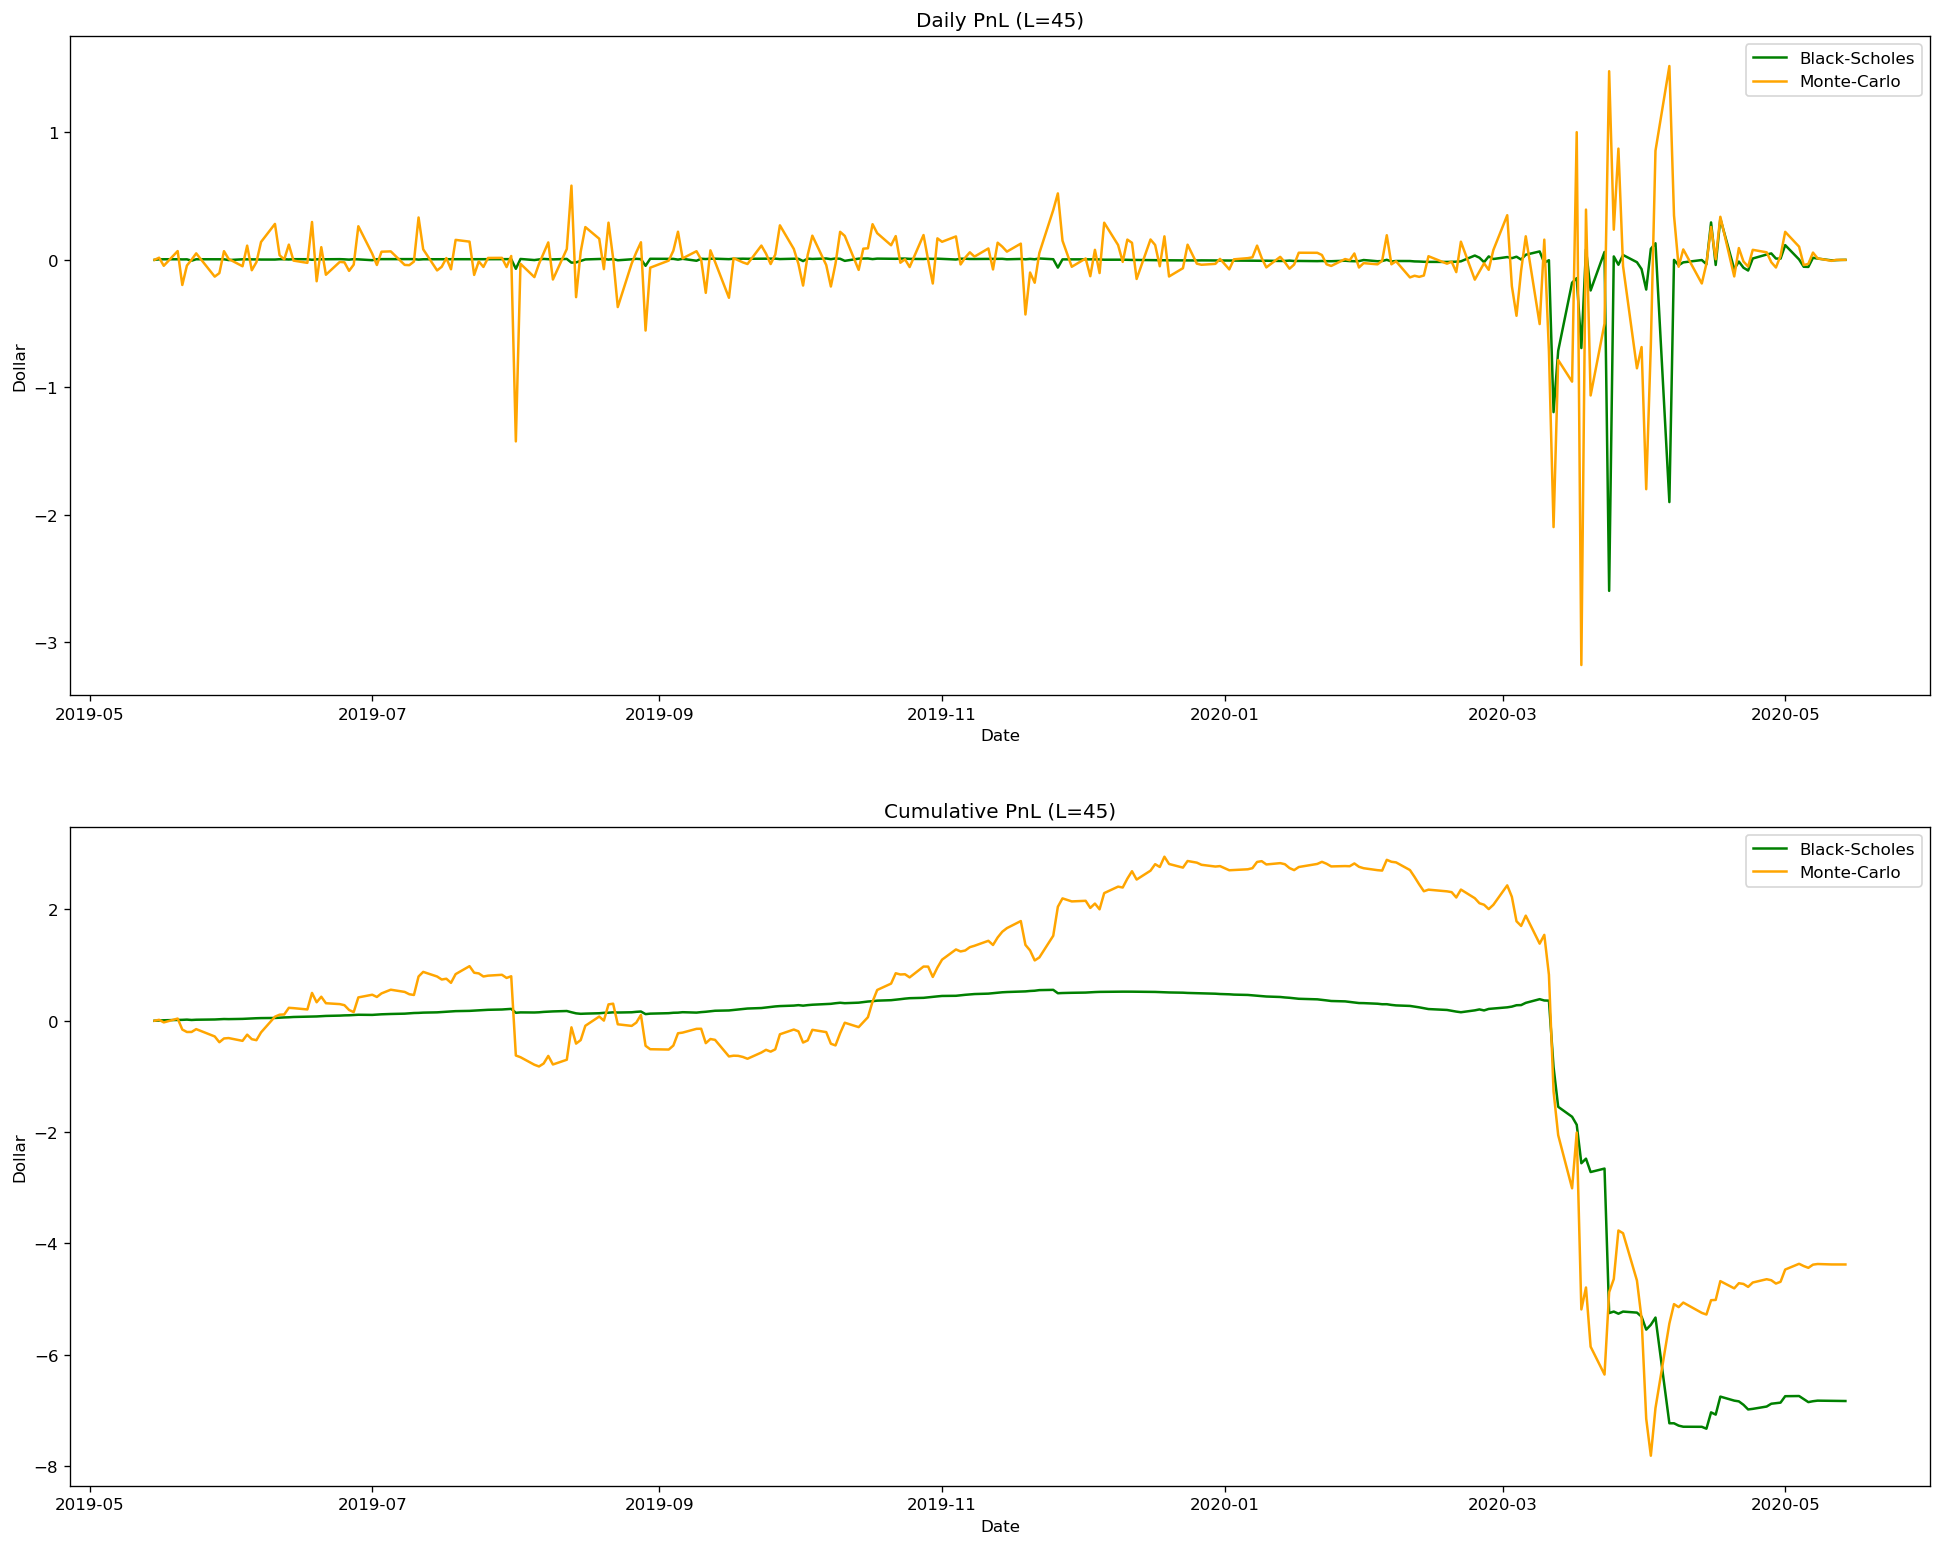

In [31]:
obj3.Plot_PnL()

In [32]:
obj3.df[obj3.df['Date'] >= "2020-03-10"]

,Date,Low,Adj Close,Return,Time,Knock-Out,BS Price,BS Delta,MC Price,MC Delta,BS PnL,BS Cumu PnL,MC PnL,MC Cumu PnL
206,2020-03-10,66.419998,69.480644,0.048602,0.817460,0,2.956915,-0.184671,2.993580,-0.323442,-0.023572,0.364150,0.158492,1.543471
207,2020-03-11,63.840000,64.773956,-0.067741,0.821429,0,3.823383,-0.168753,3.798203,-0.278687,-0.002723,0.361428,-0.717718,0.825753
208,2020-03-12,55.200001,54.894863,-0.152516,0.825397,0,4.296386,0.163724,4.455772,0.159266,-1.194122,-0.832695,-2.095604,-1.269851
209,2020-03-13,54.389999,60.503254,0.102166,0.829365,0,4.501062,-0.094856,4.563555,-0.363364,-0.713551,-1.546246,-0.785445,-2.055296
210,2020-03-16,49.009998,56.777538,-0.061579,0.833333,0,4.675625,0.054244,4.962181,-0.388293,-0.178841,-1.725087,-0.955165,-3.010461
211,2020-03-17,55.320000,59.770000,0.052705,0.837302,0,4.694518,-0.086200,4.801391,-0.537692,-0.143431,-1.868518,1.001162,-2.009300
212,2020-03-18,49.900002,54.000000,-0.096537,0.841270,0,4.500363,0.216147,4.726608,-0.119500,-0.691529,-2.560048,-3.177267,-5.186566
213,2020-03-19,48.110001,54.750000,0.013889,0.845238,0,4.744617,0.164049,5.031161,-0.134451,0.082143,-2.477905,0.394177,-4.792389
214,2020-03-20,51.590000,51.650002,-0.056621,0.849206,0,3.996110,0.392134,4.384461,-0.234069,-0.239956,-2.717861,-1.063498,-5.855887
215,2020-03-23,49.009998,50.689999,-0.018587,0.853175,0,3.681452,0.473404,4.108688,-0.049807,0.061791,-2.656070,-0.500479,-6.356366


## Compare Deltas between BS & MC

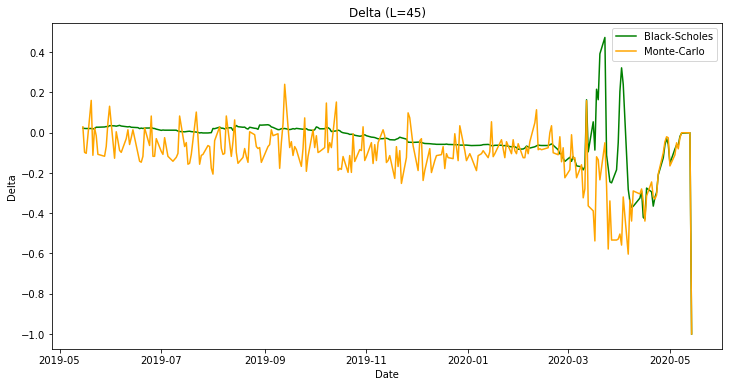

In [33]:
Plot_Delta(obj3)

## Compare Option Prices between BS & MC

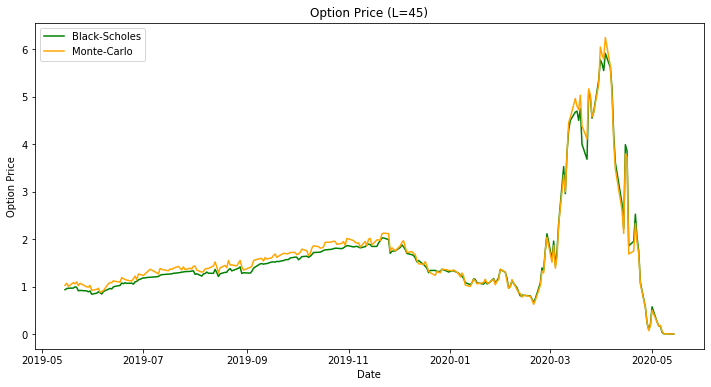

In [34]:
Plot_Option_Price(obj3)

## VaR & ES Analysis - Based on PnL

In [35]:
dfx = obj3.df.copy()
VaR = -dfx['MC PnL'].mean() + norm.ppf(0.95) * dfx['MC PnL'].std()
print("95% VaR on PnL is {:.2f}".format(VaR))

95% VaR on PnL is 0.65


In [36]:
dfxx = dfx.copy()[['MC PnL']].iloc[1:]  # Delete the first day  ->  No PnL this day
dfxx = dfxx.sort_values('MC PnL', ascending = True)
N = int( 252 * 0.05 )
ES = -dfxx['MC PnL'].iloc[:N].mean()
print("95% ES on PnL is {:.2f}".format(ES))

95% ES on PnL is 1.23
